In [1]:
import os
import json
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import json
import os
import requests
import io
import PIL
from PIL import Image as PImage
from PIL import ImageEnhance
import math
from pprint import pprint
import glob
from collections import Counter
from datetime import datetime
import shutil
import numpy as np
import math

In [2]:
API_BASE_URL = 'http://fireeye-test-backend-container:9090/api/'
TF_SERVING_BASE_URL = 'http://fireeye-test-model-container:8501/'
task_id='1ac1e8a095df4611af387d9934799251'
image_dir = './ima'
id_code_mapping = {
    'dbee3deebc5444f5b011da4e5518752c': '0',
    'edb4cb51d54644c08aa122d3f041bb0a': '1'
}

In [3]:
task_dir = os.path.join(image_dir, task_id)
train_dir = os.path.join(task_dir, 'train')
dev_dir = os.path.join(task_dir, 'dev')
test_dir = os.path.join(task_dir, 'test')

In [4]:
num_images = requests.get(
    url=API_BASE_URL+'image/count', 
    params=dict(
        task_id=task_id,
        has_truth=True
    )
).json()

print('该任务类别下的图片数量：',num_images)

该任务类别下的图片数量： 320


In [5]:
import pprint

def get_image_records(task_id):
    resp = requests.get(
        url=API_BASE_URL+'image', 
        params=dict(
            task_id=task_id,
            has_truth=True            
        )
    )
    
    if resp.status_code == 200:
        return resp.json()
    else:
        raise RuntimeError(resp.text)
image_records=get_image_records(task_id)

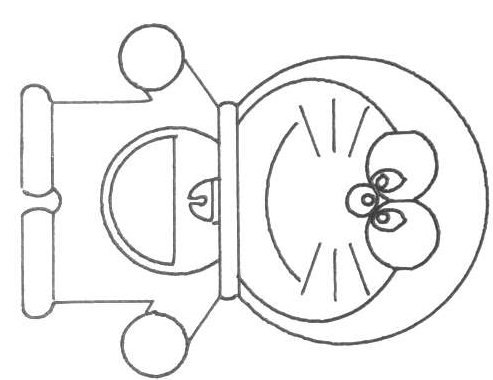

In [6]:
def get_image_by_id(id):
    r = requests.get(url=API_BASE_URL+'image/'+id)
    if r.status_code == 200:
        return PIL.Image.open(io.BytesIO(r.content))
    else:
        raise RuntimeError(r.text)
img = get_image_by_id(image_records[0]['id']) 
img.show()

In [7]:
records_by_category = {}
for record in image_records:
    category = id_code_mapping.get(str(record['truth_id']), None)
    if category is not None:
        records_by_category.setdefault(category, []).append(record)

In [8]:
def crop_by_percentile(img, lower_percentile=5, upper_percentile=95):
    img_array = np.array(img.convert('L'))
    low_val, high_val = np.percentile(img_array, [lower_percentile, upper_percentile])
    mask = np.logical_and(img_array > low_val, img_array < high_val)
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    cropped_img = img.crop((cmin, rmin, cmax, rmax))
    return cropped_img

In [9]:
def normalize_image(img: PImage.Image) -> np.ndarray:
    img_array = np.array(img)
    return img_array / 255.0

In [10]:
def color_jitter(img: PImage.Image, brightness=0.2, contrast=0.2, saturation=0.2) -> PImage.Image:
    img = ImageEnhance.Brightness(img).enhance(1 + brightness * (2 * np.random.random() - 1))
    img = ImageEnhance.Contrast(img).enhance(1 + contrast * (2 * np.random.random() - 1))
    img = ImageEnhance.Color(img).enhance(1 + saturation * (2 * np.random.random() - 1))
    return img

In [11]:
def vertical_flip(img: PImage.Image) -> PImage.Image:
    return ImageOps.flip(img)

In [12]:
def horizontal_flip(img: PImage.Image) -> PImage.Image:
    return ImageOps.mirror(img)

In [13]:
def save_image(record, directory):
    image_id = record['id']
    dst = os.path.join(directory, image_id + '.png')
    resp = requests.get(API_BASE_URL + f'image/{image_id}')
    if resp.status_code != 200:
        raise ValueError(f'Failed to get image with ID {image_id}. Response: {resp.text}')
    in_stream = io.BytesIO(resp.content)
    pimage = PImage.open(in_stream)
    pimage.save(dst)

In [14]:
def handle_category(category, records):
    np.random.shuffle(records)
    n = len(records)
    n_train = int(0.8 * n)
    n_dev = int(0.9 * n) - n_train

    for record in records[:n_train]:
        save_image(record, os.path.join(train_dir, category))
    for record in records[n_train:n_train + n_dev]:
        save_image(record, os.path.join(dev_dir, category))
    for record in records[n_train + n_dev:]:
        save_image(record, os.path.join(test_dir, category))

# Ensure directories exist
for category in records_by_category.keys():
    for directory in [train_dir, dev_dir, test_dir]:
        os.makedirs(os.path.join(directory, category), exist_ok=True)

# Use ThreadPoolExecutor to parallelize the saving of images
with ThreadPoolExecutor(max_workers=10) as executor:
    for category, records in records_by_category.items():
        executor.submit(handle_category, category, records)


In [15]:
import pathlib

train_image_count = len(list(pathlib.Path(train_dir).glob('*/*.png')))
dev_image_count = len(list(pathlib.Path(dev_dir).glob('*/*.png')))
test_image_count = len(list(pathlib.Path(test_dir).glob('*/*.png')))
print(train_image_count, dev_image_count, test_image_count)

307 59 61


In [16]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import os


img_height, img_width = 218, 175
print(tf.__version__)
batch_size = 16

2.8.2


In [17]:
def build_dataset(data_dir, target=None):
    all_images = []
    all_labels = []
    for i in range(4):
        if target is not None and i != target:
            continue
        images = glob.glob(os.path.join(data_dir, f'{i}/*.png'), recursive=True)
        all_images.extend(images)
        all_labels.extend([i] * len(images))
    ds = tf.data.Dataset.from_tensor_slices((all_images, all_labels))
    ds = ds.map(lambda x,y: (tf.io.encode_base64(tf.io.read_file(x)) ,y))
    ds = ds.shuffle(100, seed=123)
    ds = ds.batch(batch_size)
    return ds


train_ds = build_dataset(train_dir)
dev_ds = build_dataset(dev_dir)
test_ds = build_dataset(test_dir)

2023-09-16 07:38:34.573846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-16 07:38:34.573881: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-16 07:38:34.573902: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (58c881efe57c): /proc/driver/nvidia/version does not exist
2023-09-16 07:38:34.574173: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
print(train_ds)
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
(16,)
(16,)


In [19]:
def process_base64_image(s):
    img = tf.io.decode_base64(s)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width), antialias=True)    
    return img

# 构建模型
model = tf.keras.Sequential([
    layers.Lambda(
            (
                lambda x: tf.map_fn(
                    process_base64_image,
                    x,
                    fn_output_signature=tf.TensorSpec(shape=(int(img_height), int(img_width), 3), dtype=tf.float32))
            ),
            name='decode_base64_png'
        ),
    layers.Conv2D(16, 3, padding='same', activation='gelu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='gelu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='gelu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='gelu', name="dense_layer1"),
    layers.Dense(1, activation='sigmoid', name="output_layer")
])

In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [21]:
history = model.fit(
    train_ds,
    epochs=20, 
    validation_data=dev_ds
)

Epoch 1/20
20/20 [==============================] - 6s 255ms/step - loss: 545.1675 - accuracy: 0.6417 - val_loss: 107.2573 - val_accuracy: 0.5085
Epoch 2/20
20/20 [==============================] - 5s 252ms/step - loss: 61.5184 - accuracy: 0.6775 - val_loss: 3.6657 - val_accuracy: 0.5593
Epoch 3/20
20/20 [==============================] - 5s 249ms/step - loss: 13.5011 - accuracy: 0.6189 - val_loss: 0.3182 - val_accuracy: 0.9153
Epoch 4/20
20/20 [==============================] - 5s 243ms/step - loss: 0.4431 - accuracy: 0.8664 - val_loss: 0.0715 - val_accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 5s 252ms/step - loss: 0.1360 - accuracy: 0.9414 - val_loss: 0.0532 - val_accuracy: 0.9831
Epoch 6/20
20/20 [==============================] - 5s 246ms/step - loss: 0.0623 - accuracy: 0.9739 - val_loss: 0.1000 - val_accuracy: 0.9831
Epoch 7/20
20/20 [==============================] - 5s 248ms/step - loss: 0.0444 - accuracy: 0.9837 - val_loss: 0.0544 - val_accuracy: 0.9831


In [22]:
model.evaluate(test_ds)

4/4 [==============================] - 0s 78ms/step - loss: 7.9487e-05 - accuracy: 1.0000


[7.948657730594277e-05, 1.0]

In [23]:
import pytz
from datetime import datetime

model_version =  datetime.now(pytz.timezone('Asia/Shanghai')).strftime('%Y%m%d%H%M%S')
tf.keras.models.save_model(
    model,
    f'/models/slot1/{model_version}/',
    overwrite=True,
)

2023-09-16 07:40:14.939195: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /models/slot1/20230916154014/assets


In [26]:
import base64

def predict_image(images):    
    bimages = []
    for image in images:
        with open(image, 'rb') as  fimage:
            content = fimage.read()
        bimage = base64.urlsafe_b64encode(content).decode()
        bimages.append(bimage)
    req_data ={
      'inputs': bimages,
    }
    response = requests.post(TF_SERVING_BASE_URL+f'v1/models/slot1/versions/{model_version}:predict', # 根据部署地址填写
                             json=req_data,
                             headers={"content-type": "application/json"})
    if response.status_code != 200:
        raise RuntimeError('Request tf-serving failed: ' + response.text)
    resp_data = json.loads(response.text)    
    if 'outputs' not in resp_data \
                        or type(resp_data['outputs']) is not list:
        raise ValueError('Malformed tf-serving response')
    outputs = np.argmax(resp_data['outputs'], axis=1).tolist()
    return outputs


def test_image_model(test_dir, code, batch_size=10):    
    images = list(pathlib.Path(test_dir).joinpath(str(code)).glob('./*.png')) 
    codes = []
    for step in range(math.ceil(len(images)/batch_size)):
        outputs = predict_image(images[step*batch_size:(step+1)*batch_size])
        for i, o in zip(images, outputs):            
            if o != code:
                print('错误图片：', i)
        codes.extend(outputs)
    accuracy = round(codes.count(code) / len(codes), 4)
    return accuracy, codes

accuracy, codes = test_image_model(dev_dir, 0)
print('类别0的准确率', accuracy)
print('类别0的测试结果', codes)
accuracy, codes = test_image_model(dev_dir, 1)
print('类别1的准确率', accuracy)
print('类别1的测试结果', codes)

类别0的准确率 1.0
类别0的测试结果 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
错误图片： ima/1ac1e8a095df4611af387d9934799251/dev/1/01c098e6-3727-4401-9440-d91116b9f994.png
错误图片： ima/1ac1e8a095df4611af387d9934799251/dev/1/1d69b451ae2d496c836924b28451c6af.png
错误图片： ima/1ac1e8a095df4611af387d9934799251/dev/1/21fe89e2-ee62-4424-84e0-4cd21cf83780.png
错误图片： ima/1ac1e8a095df4611af387d9934799251/dev/1/13e18949b7214bf2b8f740d8866d3417.png
错误图片： ima/1ac1e8a095df4611af387d9934799251/dev/1/8c49775f05d3477fbbdb994a4175640e.png
错误图片： ima/1ac1e8a095df4611af387d9934799251/dev/1/a4c5e89db617458680aadfa1e6319588.png
错误图片： ima/1ac1e8a095df4611af387d9934799251/dev/1/ad75804cd010445089954ca6d578b650.png
错误图片： ima/1ac1e8a095df4611af387d9934799251/dev/1/c9266cf7-2990-4d2e-8e08-22a822088fae.png
错误图片： ima/1ac1e8a095df4611af387d9934799251/dev/1/14499d28ccfe427189d12e767505a557.png
错误图片： ima/1ac1e8a095df4611af387d9934799251/dev/1/14c47056657648679cd9f1f77067a575.png
错误图片： ima/1ac1e8a09